# Provided Code

In [45]:
#imports and Drive mounting
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

print(tf.__version__)

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk
import pandas as pd
import os

# fix random seed for reproducibility
seed = 2020
np.random.seed(seed)  

from sklearn.model_selection import train_test_split

from tensorflow.keras.datasets import cifar100
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization, Activation
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model

2.1.0


In [46]:
from google.colab import drive
drive.mount('/content/gdrive')

#!ls '/content/gdrive/My Drive/'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
# helper functions for visualisation
def plot_history(history):
  plt.figure(figsize = (12,4))
  plt.subplot(1,2,1)

  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.plot(history.epoch, np.array(history.history['accuracy']),'g-',
           label='Train accuracy')
  plt.plot(history.epoch, np.array(history.history['val_accuracy']),'r-',
           label = 'Validation accuracy')
  plt.ylim([0.0,1.0])
  plt.legend()

  plt.subplot(1,2,2)
  plt.xlabel('Epoch')
  plt.ylabel('Loss minimised by model')
  plt.plot(history.epoch, np.array(history.history['loss']),'g-',
           label='Train loss')
  plt.plot(history.epoch, np.array(history.history['val_loss']),'r-',
           label = 'Validation loss')
  plt.legend()

In [48]:
# Load the data: CIFAR100 with 20 class labels
(x_train_all, r_train_all_class), ( _ , _ ) = cifar100.load_data(label_mode='coarse')

num_classes = 20

val_size = 5000
# make validation set
x_train, x_val, r_train_class, r_val_class = train_test_split(x_train_all, r_train_all_class, test_size=val_size, random_state=0)

# let's again take a subset of the training data first, for playing around
# Note that such a subset is only useful if it can guide your tuning process,
# i.e., if it leads you to similar decisions as you would make on the whole training set

# In this case, 10000 samples is really too small: you can check this by comparing the validation curves 
# for 10000 training samples with those for all training samples. 
# The validation accuracy should not be very different!
x_train_small = x_train[:16384]
r_train_small_class = r_train_class[:16384]

# And we do the same standardization as in the first assignment
x_train_all = x_train_all.astype('float32')
x_train = x_train.astype('float32')
x_train_small = x_train_small.astype('float32')
x_val = x_val.astype('float32')

x_train_all /= 255.0
x_train /= 255.0
x_train_small /= 255.0
x_val /= 255.0

# the labels from the downloaded data are integer numbers
# for a multi-class classification task, we again convert each integer
# to a vector with 19 zeros and a single '1', corresponding to the right class
r_train_all = tf.keras.utils.to_categorical(r_train_all_class, num_classes)
r_train = tf.keras.utils.to_categorical(r_train_class, num_classes)
r_train_small = tf.keras.utils.to_categorical(r_train_small_class, num_classes)
r_val = tf.keras.utils.to_categorical(r_val_class, num_classes)


# Labels
labels = [
'aquatic mammals',
'fish',
'flowers',
'food containers',
'fruit and vegetables',
'household electrical devices',
'household furniture',
'insects',
'large carnivores',
'large man-made outdoor things',
'large natural outdoor scenes',
'large omnivores and herbivores',
'medium-sized mammals',
'non-insect invertebrates',
'people',
'reptiles',
'small mammals',
'trees',
'vehicles 1',
'vehicles 2'
]

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_val.shape[0], 'validation samples')

x_train shape: (45000, 32, 32, 3)
45000 train samples
5000 validation samples


# First Complex Model


In [0]:
# First, make the model more complex to lower bias
def complex_model(learning_rate=0.001):
  model = Sequential([
    # 1
    Conv2D(64, (3,3), padding='same', kernel_initializer='he_uniform', input_shape=x_train.shape[1:]),
    BatchNormalization(),
    Activation('relu'),
    
    # 2
    Conv2D(128, (3,3), padding='same', kernel_initializer='he_uniform'),
    BatchNormalization(),
    Activation('relu'),

    # 3
    Conv2D(128, (3,3), padding='same', kernel_initializer='he_uniform'),
    BatchNormalization(momentum=0.95),
    Activation('relu'),

    # 4
    Conv2D(128, (3,3), padding='same', kernel_initializer='he_uniform'),
    BatchNormalization(momentum=0.95),
    Activation('relu'),
    # First Maxpooling
    MaxPooling2D(pool_size=(2,2), strides=2),

    # 5
    Conv2D(128, (3,3), padding='same', kernel_initializer='he_uniform'),
    BatchNormalization(momentum=0.95),
    Activation('relu'),

    # 6
    Conv2D(128, (3,3), padding='same', kernel_initializer='he_uniform'),
    BatchNormalization(momentum=0.95),
    Activation('relu'),

    # 7
    Conv2D(256, (3,3), padding='same', kernel_initializer='he_uniform'),
    BatchNormalization(momentum=0.95),
    Activation('relu'),
    # Second Maxpooling
    MaxPooling2D(pool_size=(2,2), strides=2),

    # 8
    Conv2D(256, (3,3), padding='same', kernel_initializer='he_uniform'),
    BatchNormalization(momentum=0.95),
    Activation('relu'),

    # 9
    Conv2D(256, (3,3), padding='same', kernel_initializer='he_uniform'),
    BatchNormalization(momentum=0.95),
    Activation('relu'),
    # Third Maxpooling
    MaxPooling2D(pool_size=(2,2), strides=2),

    # 10
    Conv2D(512, (3,3), padding='same', kernel_initializer='he_uniform'),
    BatchNormalization(momentum=0.95),
    Activation('relu'),

    # 11
    Conv2D(2048, (1,1), padding='same', kernel_initializer='he_uniform'),
    BatchNormalization(momentum=0.95),
    Activation('relu'),

    # 12
    Conv2D(256, (1,1), padding='same', kernel_initializer='he_uniform'),
    BatchNormalization(momentum=0.95),
    Activation('relu'),
    # Fourth Maxpooling
    MaxPooling2D(pool_size=(2,2), strides=2),

    # 13
    Conv2D(256, (3,3), padding='same', kernel_initializer='he_uniform'),
    # Fifth Maxpooling
    MaxPooling2D(pool_size=(2,2), strides=2),

    Flatten(),
    Dense(num_classes),
    Activation('softmax')
  ])

  opt = Adam(learning_rate=learning_rate)

  model.compile(loss='categorical_crossentropy',
                optimizer=opt,
                metrics=['accuracy'])

  return model

In [54]:
model = complex_model(learning_rate=0.001)
model.summary()

batch_size = 256
epochs = 25

checkpoint_dir = "/content/gdrive/My Drive/Colab Notebooks/DL2020/GA1/"
print("Models will be saved in ",checkpoint_dir)
model_savename = checkpoint_dir+"initialmodel_model_version_0.1.h5"
checkpoint_path = checkpoint_dir+"cp-{epoch:04d}.ckpt"

mc_callback = ModelCheckpoint(checkpoint_path,
                              monitor='val_accuracy',
                              save_weights_only=True,
                              save_best_only=True,
                              verbose=1)

history = model.fit(x_train, r_train,
          batch_size=batch_size,
          epochs=epochs,
          callbacks = [mc_callback],
          validation_data=(x_val, r_val),
          shuffle=True)

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_120 (Conv2D)          (None, 32, 32, 64)        1792      
_________________________________________________________________
batch_normalization_116 (Bat (None, 32, 32, 64)        256       
_________________________________________________________________
activation_151 (Activation)  (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_121 (Conv2D)          (None, 32, 32, 128)       73856     
_________________________________________________________________
batch_normalization_117 (Bat (None, 32, 32, 128)       512       
_________________________________________________________________
activation_152 (Activation)  (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_122 (Conv2D)          (None, 32, 32, 128)     

KeyboardInterrupt: ignored

Training set Accuracy:   1.00
Training set Loss: 0.0023

Validation set Accuracy:   0.58
Validation set Loss: 2.3360



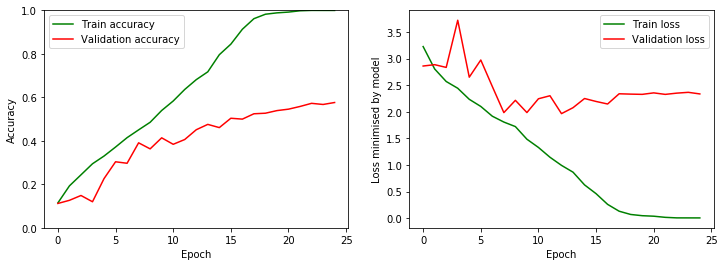

In [53]:
# We analyse the result:
[train_loss, train_accuracy] = model.evaluate(x_train_small, r_train_small, verbose=0)
print("Training set Accuracy:{:7.2f}".format(train_accuracy))
print("Training set Loss:{:7.4f}\n".format(train_loss))

[val_loss, val_accuracy] = model.evaluate(x_val, r_val, verbose=0)
print("Validation set Accuracy:{:7.2f}".format(val_accuracy))
print("Validation set Loss:{:7.4f}\n".format(val_loss))

# Now we visualise what happened during training
plot_history(history)

# Regularizing

In [0]:
# Then, add regularization
def complex_model(learning_rate=0.001):
  model = Sequential([
    # 1
    Conv2D(64, (3,3), padding='same', kernel_initializer='he_uniform', input_shape=x_train.shape[1:]),
    BatchNormalization(),
    Activation('relu'),
    
    # 2
    Conv2D(128, (3,3), padding='same', kernel_initializer='he_uniform'),
    BatchNormalization(),
    Activation('relu'),

    # 3
    Conv2D(128, (3,3), padding='same', kernel_initializer='he_uniform'),
    BatchNormalization(momentum=0.95),
    Activation('relu'),

    # 4
    Conv2D(128, (3,3), padding='same', kernel_initializer='he_uniform'),
    BatchNormalization(momentum=0.95),
    Activation('relu'),
    # First Maxpooling
    MaxPooling2D(pool_size=(2,2), strides=2),

    # 5
    Conv2D(128, (3,3), padding='same', kernel_initializer='he_uniform'),
    BatchNormalization(momentum=0.95),
    Activation('relu'),

    # 6
    Conv2D(128, (3,3), padding='same', kernel_initializer='he_uniform'),
    BatchNormalization(momentum=0.95),
    Activation('relu'),

    # 7
    Conv2D(256, (3,3), padding='same', kernel_initializer='he_uniform'),
    BatchNormalization(momentum=0.95),
    Activation('relu'),
    # Second Maxpooling
    MaxPooling2D(pool_size=(2,2), strides=2),

    # 8
    Conv2D(256, (3,3), padding='same', kernel_initializer='he_uniform'),
    BatchNormalization(momentum=0.95),
    Activation('relu'),

    # 9
    Conv2D(256, (3,3), padding='same', kernel_initializer='he_uniform'),
    BatchNormalization(momentum=0.95),
    Activation('relu'),
    # Third Maxpooling
    MaxPooling2D(pool_size=(2,2), strides=2),

    # 10
    Conv2D(512, (3,3), padding='same', kernel_initializer='he_uniform'),
    BatchNormalization(momentum=0.95),
    Activation('relu'),

    # 11
    Conv2D(2048, (1,1), padding='same', kernel_initializer='he_uniform'),
    BatchNormalization(momentum=0.95),
    Activation('relu'),

    # 12
    Conv2D(256, (1,1), padding='same', kernel_initializer='he_uniform'),
    BatchNormalization(momentum=0.95),
    Activation('relu'),
    # Fourth Maxpooling
    MaxPooling2D(pool_size=(2,2), strides=2),

    # 13
    Conv2D(256, (3,3), padding='same', kernel_initializer='he_uniform'),
    # Fifth Maxpooling
    MaxPooling2D(pool_size=(2,2), strides=2),

    Flatten(),
    # dropout
    Dropout(0.2),
    Dense(num_classes),
    Activation('softmax')
  ])

  opt = Adam(learning_rate=learning_rate)

  model.compile(loss='categorical_crossentropy',
                optimizer=opt,
                metrics=['accuracy'])

  return model

In [0]:
model = complex_model(learning_rate=0.001)
model.summary()

epochs=50

# data augmentation
datagen = ImageDataGenerator(
        rotation_range=22.5,
        width_shift_range=0.2,
        height_shift_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=False,
        fill_mode='nearest')

# early stopping
es_callback = EarlyStopping(monitor='val_accuracy', patience=5, min_delta=0.0001)

history = model.fit(datagen.flow(x_train_small, r_train_small, batch_size=batch_size),
          epochs=epochs,
          callbacks = [mc_callback],#, es_callback],
          validation_data=(x_val, r_val),
          shuffle=True)

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_146 (Conv2D)          (None, 32, 32, 64)        1792      
_________________________________________________________________
batch_normalization_140 (Bat (None, 32, 32, 64)        256       
_________________________________________________________________
activation_177 (Activation)  (None, 32, 32, 64)        0         
_________________________________________________________________
dropout_14 (Dropout)         (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_147 (Conv2D)          (None, 32, 32, 128)       73856     
_________________________________________________________________
batch_normalization_141 (Bat (None, 32, 32, 128)       512       
_________________________________________________________________
activation_178 (Activation)  (None, 32, 32, 128)     

Training set Accuracy:   0.07
Training set Loss: 3.3587

Validation set Accuracy:   0.07
Validation set Loss: 3.3901



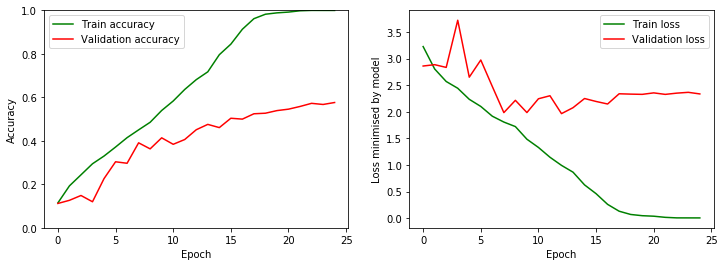

In [58]:
# We analyse the result:
[train_loss, train_accuracy] = model.evaluate(x_train_small, r_train_small, verbose=0)
print("Training set Accuracy:{:7.2f}".format(train_accuracy))
print("Training set Loss:{:7.4f}\n".format(train_loss))

[val_loss, val_accuracy] = model.evaluate(x_val, r_val, verbose=0)
print("Validation set Accuracy:{:7.2f}".format(val_accuracy))
print("Validation set Loss:{:7.4f}\n".format(val_loss))

# Now we visualise what happened during training
plot_history(history)

In [0]:
# retrain on all data
history = model.fit(datagen.flow(x_train_all, r_train_all, batch_size=batch_size),
          epochs=epochs,
          callbacks = [mc_callback],#, es_callback],
          validation_data=(x_val, r_val),
          shuffle=True)